In [147]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing


In [134]:
tsla_df = yf.download('TSLA', 
                      start='2019-01-01', 
                      end='2019-12-31', 
                      progress=False)
tsla_df.head()

Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2018-12-31  22.519333  22.614000  21.684000  22.186666  22.186666   94534500
2019-01-02  20.406668  21.008667  19.920000  20.674667  20.674667  174879000
2019-01-03  20.466667  20.626667  19.825333  20.024000  20.024000  104478000
2019-01-04  20.400000  21.200001  20.181999  21.179333  21.179333  110911500
2019-01-07  21.448000  22.449333  21.183332  22.330667  22.330667  113268000

In [135]:
dow_30_tickers = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO',
                 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ',
                 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 
                 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V',
                 'WBA', 'WMT', 'DIS', 'DOW']

In [136]:
def add_ticker_name(df, ticker):
    df.set_axis([ticker + '_' + col for col in list(df.columns)], axis=1, inplace=True)
    return df

On va commencer par prendre un df avec 2 stock, on va calculer les indic (mva, rsi etc) et tout les jours en acheter un et short l'autre

In [137]:
df = yf.download('AXP', start = '2015-01-01')

[*********************100%***********************]  1 of 1 completed


In [138]:
### Functions to get classical Technical Trading indicators

# Simple Moving Average 
def SMA(data, ndays): 
    data['SMA_'+str(ndays)] = pd.Series(data['Close'].rolling(ndays).mean())
    return data

# Exponentially-weighted Moving Average 
def EWMA(data, ndays): 
    data['EWMA_' + str(ndays)] = pd.Series(data['Close'].ewm(span = ndays, min_periods = ndays - 1).mean())
    return data

def rsi(df, periods = 14):
    
    close = df.Close
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    
    df['rsi_' + str(periods)] = rsi
    return df

def gain(x):
    return ((x > 0) * x).sum()
def loss(x):
    return ((x < 0) * x).sum()


# Calculate money flow index
def mfi(df, n=14):
    typical_price = (df.High + df.Low + df.Close)/3
    money_flow = typical_price * df.Volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    mfi = (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()
    
    df['mfi_' + str(n)] = mfi
    
    return df
    
    # Returns ATR values
def atr(df, n=14):
    tr = np.amax(np.vstack(((df.High - df.Low).to_numpy(), (abs(df.High - df.Close)).to_numpy(), (abs(df.Low - df.Close)).to_numpy())).T, axis=1)    
    atr = pd.Series(tr).rolling(n).mean().to_numpy()
    df['atr_' + str(n)] = atr
    return df

def ForceIndex(data, ndays = 1): 
    data['ForceIndex_' + str(ndays)] = pd.Series(data['Close'].diff(ndays) * data['Volume']) 
    return data

def EMV(data, ndays = 14): 
    dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
    br = (data['Volume'] / 100000000) / ((data['High'] - data['Low']))
    EMV = dm / br 
    EMV_MA = pd.Series(EMV.rolling(ndays).mean(), name = 'EMV') 
    data['EMV_MA_' + str(ndays)] = EMV_MA
    return data 


def get_all_technical_indicators(data):

    data = SMA(data, 5)
    data = SMA(data, 50)
    data = SMA(data, 200)
    
    data = EWMA(data, 5)
    data = EWMA(data, 50)
    data = EWMA(data, 200)
    
    data = rsi(data)
    data = mfi(data)
    data = atr(data)
    data = ForceIndex(data)
    data = EMV(data)
    
    return data

In [139]:
df = get_all_technical_indicators(df)

In [140]:
df.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-10-21  140.990005  141.320007  132.210007  140.039993  140.039993   
2022-10-24  141.300003  143.789993  140.369995  141.630005  141.630005   
2022-10-25  142.479996  147.440002  141.600006  147.020004  147.020004   
2022-10-26  147.559998  149.500000  146.470001  146.880005  146.880005   
2022-10-27  148.440002  149.710007  146.410004  146.970001  146.970001   

              Volume       SMA_5      SMA_50    SMA_200      EWMA_5  \
Date                                                                  
2022-10-21  11745300  142.791998  149.669800  163.63290  141.638097   
2022-10-24   4299600  142.810001  149.185600  163.47655  141.635400   
2022-10-25   3889100  143.016000  148.818000  163.33975  143.430268   
2022-10-26   3559100  143.598001  148.448600  163.20545  144.580180   
2022-10-27   2101300  144.508002  148.110001  163.06340  145.376787   

               EWMA_50    EWMA_200     rsi_14     mfi_14    atr_14  \
Date                                                                 
2022-10-21  146.586403  156.861335  45.284982  35.637821  4.698574   
2022-10-24  146.392035  156.709780  47.577284  37.842221  4.762859   
2022-10-25  146.416661  156.613364  54.531512  43.713049  4.950716   
2022-10-26  146.434831  156.516515  54.329912  49.334985  4.957860   
2022-10-27  146.455818  156.421524  54.446499  53.506562  4.964289   

            ForceIndex_1  EMV_MA_14  
Date                                 
2022-10-21 -2.795387e+07   1.281224  
2022-10-24  6.836414e+06 -16.682195  
2022-10-25  2.096225e+07  16.178296  
2022-10-26 -4.982718e+05  37.994543  
2022-10-27  1.891093e+05  73.594968

In [170]:
# Function to prepare data for models

# add label to data (one day return):

def add_next_day_return(df):
    
    close_start = np.array(df.Close[0:-1])
    close_end = np.array(df.Close[1:])
    one_day_return = (close_end - close_start) / close_start    
    
    df = df[0:-1]
    #df['One_day_return'] = one_day_return
    df.loc[:,'Next_day_return'] = one_day_return
    
    return df


def sep_train_test(df, date_start_train = '2015-01-01', date_end_train = '2021-01-01'):
    
    df = df.dropna()
    
    train = df[df.index < date_end_train]
    train = train[train.index >= date_start_train]
    
    test = df[df.index >= date_end_train]
    
    y_train = train.pop('Next_day_return')
    
    y_test = test.pop('Next_day_return')

    
    return train, y_train, test, y_test


def sep_train_test(df, date_start_train = '2015-01-01', date_end_train = '2021-01-01'):
    
    df = df.dropna()
    
    train = df[df.index < date_end_train]
    train = train[train.index >= date_start_train]
    
    test = df[df.index >= date_end_train]
    
    y_train = train.pop('Next_day_return')
    
    y_test = test.pop('Next_day_return')

    
    return train, y_train, test, y_test



def sep_train_test_scaled(df, date_start_train = '2015-01-01', date_end_train = '2021-01-01'):
    
    df = df.dropna()
    
    
    x = df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_scaled = pd.DataFrame(x_scaled)

    
    train = df_scaled[df_scaled.index < len(df[df.index < '2021-01-01'])]
    #train = train[train.index >= date_start_train]
    
    test = df_scaled[df_scaled.index >= len(df[df.index < '2021-01-01'])]
    
    y_train = train.pop(list(df_scaled.columns)[-1])
    
    y_test = test.pop(list(df_scaled.columns)[-1])

    
    return train, y_train, test, y_test



In [203]:
df = add_next_day_return(df)

date_start_train = '2015-01-01'
date_end_train = '2021-01-01'

X_train, y_train, X_test, y_test = sep_train_test(df, date_start_train, date_end_train)

X_scaled_train, y_scaled_train, X_scaled_test, y_scaled_test = sep_train_test_scaled(df, date_start_train, date_end_train)

/var/folders/9y/9ztxqzcx64j6np_fxsty2gy80000gn/T/ipykernel_13715/4193621717.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Next_day_return'] = one_day_return


In [213]:
X_scaled_train.index = list(X_train.index)
y_scaled_train.index = list(y_train.index)
X_scaled_test.index = list(X_test.index)
y_scaled_test.index = list(y_test.index)

In [205]:
len(X_scaled_train)

1313

In [217]:
len(X_test)

453

In [218]:
len(X_scaled_test)

453

## First test : try to do a regression on one day return for one stock

### RF Regressor

In [220]:
RF_reg = RandomForestRegressor(max_depth=10, random_state=0)
RF_reg.fit(X_scaled_train, y_scaled_train)

y_scaled_pred = RF_reg.predict(X_scaled_test)
y_scaled_train_pred = RF_reg.predict(X_scaled_train)

In [181]:
new = pd.DataFrame(y_train, y_train_pred)

In [182]:
test_res = X_train.copy()
test_res['y_train_pred'] = y_train_pred
test_res['y_train'] = y_train
test_res = test_res[['y_train', 'y_train_pred']]

In [187]:
for i in range(10):
    print(test_res['y_train_pred'].quantile(i/10))

0.12406805276750886
0.40185876921364816
0.40409958801836504
0.40485866847230884
0.40516748922544893
0.40529513759295627
0.40539934839086755
0.405528753820287
0.4059638735689763
0.408806368826515


In [195]:
np.quantile(y_pred, 0.75)

0.3724624223673838

In [183]:
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_test, y_pred)

26.450761122537443

## Implement our strategy

We will buy the stock at Close Price if we have a buy signal and sell it at Close Price as soon as the buy signal is over

In [221]:
test = X_scaled_test
test['y_pred'] = y_scaled_pred

def buy_signal(row):
    if(row['y_pred'] < np.quantile(y_pred, 0.75)):
        val = 0
    else:
        val = 1
    return val

test['buy_signal'] = test.apply(buy_signal, axis=1)


In [222]:
X_test['buy_signal'] = test['buy_signal']

In [223]:
X_test

Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-01-04  121.300003  121.800003  116.849998  118.040001  115.185806   
2021-01-05  118.260002  119.279999  117.099998  118.669998  115.800575   
2021-01-06  121.000000  124.730003  120.809998  123.059998  120.084427   
2021-01-07  124.099998  125.690002  117.349998  121.660004  119.134560   
2021-01-08  122.070000  122.199997  119.519997  121.779999  119.252083   
...                ...         ...         ...         ...         ...   
2022-10-13  131.350006  142.550003  130.649994  141.550003  141.550003   
2022-10-14  142.960007  143.880005  136.139999  136.809998  136.809998   
2022-10-17  140.580002  142.220001  140.089996  141.539993  141.539993   
2022-10-18  146.130005  147.050003  143.550003  145.990005  145.990005   
2022-10-19  145.429993  147.070007  142.600006  143.970001  143.970001   

             Volume       SMA_5    SMA_50    SMA_200      EWMA_5     EWMA_50  \
Date                                                                           
2021-01-04  3472100  118.976001  112.9798   99.88940  118.781698  114.443484   
2021-01-05  2112700  119.038000  113.2574  100.11215  118.744464  114.609229   
2021-01-06  5861500  120.022000  113.6990  100.38265  120.182975  114.940632   
2021-01-07  8696600  120.468001  114.1946  100.57070  120.675318  115.204137   
2021-01-08  2934500  120.642000  114.7316  100.72875  121.043545  115.462014   
...             ...         ...       ...        ...         ...         ...   
2022-10-13  5232300  138.430002  151.7722  164.40490  139.383352  147.872540   
2022-10-14  3871900  137.992001  151.3710  164.26980  138.525567  147.438714   
2022-10-17  3139300  138.798001  151.0516  164.15670  139.530376  147.207392   
2022-10-18  3963300  140.526001  150.8258  164.06865  141.683586  147.159651   
2022-10-19  2803900  141.972000  150.5292  163.94745  142.445724  147.034567   

              EWMA_200     rsi_14     mfi_14    atr_14  ForceIndex_1  \
Date                                                                   
2021-01-04  107.009248  51.298608  35.758067  2.575714 -9.964937e+06   
2021-01-05  107.125276  52.789745  38.383854  2.364286  1.330995e+06   
2021-01-06  107.283830  61.610392  50.400996  2.376429  2.573198e+07   
2021-01-07  107.426877  57.895427  38.830844  2.878572 -1.217519e+07   
2021-01-08  107.569694  58.128473  32.001130  2.983572  3.521257e+05   
...                ...        ...        ...       ...           ...   
2022-10-13  157.792150  45.829671  36.181186  4.300000  2.516735e+07   
2022-10-14  157.583372  40.174411  45.041168  4.525000 -1.835283e+07   
2022-10-17  157.423736  47.178948  51.939608  4.371429  1.484888e+07   
2022-10-18  157.309968  52.780391  50.658679  4.288573  1.763673e+07   
2022-10-19  157.177232  50.179086  49.887011  4.385716 -5.663890e+06   

            EMV_MA_14  buy_signal  
Date                               
2021-01-04  -6.783815           1  
2021-01-05 -12.053203           1  
2021-01-06  20.382418           1  
2021-01-07   7.051911           1  
2021-01-08   2.446571           1  
...               ...         ...  
2022-10-13 -43.252128           0  
2022-10-14  14.304743           0  
2022-10-17  28.013477           0  
2022-10-18  50.306527           0  
2022-10-19  59.183411           0  

[453 rows x 18 columns]

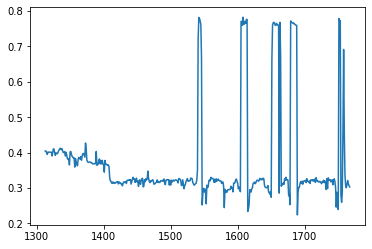

In [198]:
plt.plot(test['y_pred'])

In [237]:
# We only buy one stock and sell one stock

trades = []

shares_bought = [0 for i in range(len(X_test))]
shares_sold = [0 for i in range(len(X_test))]


i = 0
is_bought = 0
while(i < (len(X_test))):
    if(is_bought):
        if(X_test.iloc[i]['buy_signal'] == 0):
            price_sell = X_test.iloc[i]['Close']
            trades.append(price_sell - price_bought)
            is_bought = 0
    else:
        if((X_test.iloc[i]['buy_signal'] == 1)):
            price_bought = X_test.iloc[i]['Close']
            is_bought = 1
    i += 1
    

In [252]:
# We invest money_invested on our strategy

trades = []
money_invested = 10000

money_available = money_invested
current_portfolio_value = []

num_shares_bought = [0 for i in range(len(X_test))]
num_shares_sold = [0 for i in range(len(X_test))]


i = 0
is_bought = 0
current_num_shares = 0

while(i < (len(X_test))):
    if(is_bought):
        if(X_test.iloc[i]['buy_signal'] == 0):
            price_sell = X_test.iloc[i]['Close']
            #trades.append(price_sell - price_bought)
            is_bought = 0
            
            num_shares_sold[i] = current_num_shares
            money_available += current_num_shares * price_sell
            
            current_num_shares = 0
            
    else:
        if((X_test.iloc[i]['buy_signal'] == 1)):
            price_bought = X_test.iloc[i]['Close']
            is_bought = 1
            
            num_shares_bought[i] = money_available // X_test.iloc[i].Close
            current_num_shares = num_shares_bought[i]
            money_available -=  current_num_shares * price_bought
            #current_portfolio = current_portfolio - num_shares * X_test.iloc[0].Close
            
    current_portfolio_value.append(money_available + current_num_shares * X_test.iloc[i].Close)
    
    i += 1
    

In [262]:
# Baseline : buy and hold strategy

money_invested = 10000
money_available_baseline = money_invested

current_portfolio_baseline_value = []

num_shares_baseline =  money_invested // X_test.iloc[0]['Close']
money_available_baseline = money_invested % X_test.iloc[0]['Close']

for i in range(len(X_test)):
    current_portfolio_baseline_value.append(money_available_baseline + num_shares_baseline * X_test.iloc[i].Close)

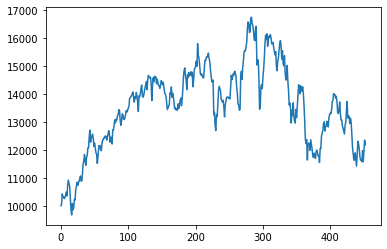

In [264]:
plt.plot(current_portfolio_baseline_value)

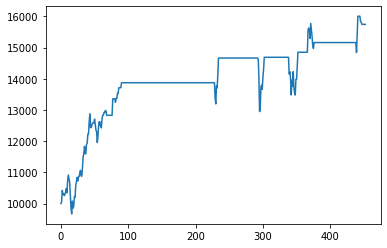

In [254]:
plt.plot(current_portfolio_value)

In [239]:
X_test.iloc[0].Close

118.04000091552734

In [244]:
money_invested = 10000
current_portfolio = money_invested

num_shares = (current_portfolio//X_test.iloc[0].Close)
current_portfolio = current_portfolio - num_shares * X_test.iloc[0].Close

In [245]:
num_shares

84.0

In [246]:
current_portfolio

84.63992309570312

In [248]:
num_shares * X_test.iloc[0].Close + current_portfolio

10000.0

In [238]:
trades

[19.040000915527344,
 9.840011596679688,
 1.7899932861328125,
 3.8300018310546875,
 -1.04998779296875,
 6.0099945068359375,
 0.1699981689453125,
 1.8600006103515625,
 2.0999908447265625,
 1.779998779296875,
 9.089996337890625,
 0.3000030517578125,
 -8.110000610351562,
 9.739990234375,
 2.899993896484375,
 7.670013427734375,
 -2.2599945068359375]

In [232]:
X_test.iloc[0]['buy_signal']

1.0

In [118]:
test.sort_values(by = 0)

0
303 -0.039229
302 -0.038053
376 -0.035980
437 -0.034591
436 -0.034591
..        ...
368  0.145424
369  0.145424
366  0.146148
438  0.146148
440  0.146941

[455 rows x 1 columns]

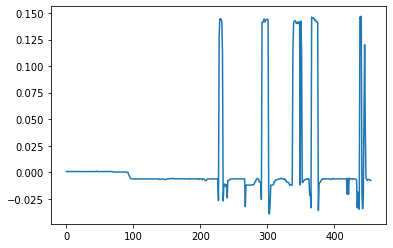

In [121]:
plt.plot(test)

In [33]:
df = add_ticker_name(df, 'AXP')


AXP_Open    AXP_High     AXP_Low   AXP_Close  AXP_Adj Close  \
Date                                                                        
2014-12-31   94.650002   94.750000   93.000000   93.040001      82.503960   
2015-01-02   93.169998   93.940002   92.139999   93.019997      82.486229   
2015-01-05   92.459999   92.779999   90.320000   90.559998      80.304817   
2015-01-06   90.790001   90.900002   87.940002   88.629997      78.593353   
2015-01-07   91.010002   91.010002   89.529999   90.300003      80.309822   
...                ...         ...         ...         ...            ...   
2022-10-19  145.429993  147.070007  142.600006  143.970001     143.970001   
2022-10-20  144.000000  147.320007  142.149994  142.419998     142.419998   
2022-10-21  140.990005  141.320007  132.210007  140.039993     140.039993   
2022-10-24  141.300003  143.789993  140.369995  141.630005     141.630005   
2022-10-25  142.479996  147.440002  141.600006  147.020004     147.020004   

            AXP_Volume  
Date                    
2014-12-31     2306200  
2015-01-02     2437500  
2015-01-05     3469600  
2015-01-06     4800300  
2015-01-07     5665200  
...                ...  
2022-10-19     2803900  
2022-10-20     4319300  
2022-10-21    11745300  
2022-10-24     4299600  
2022-10-25     3879000  

[1969 rows x 6 columns]

In [20]:
df = 
for tic in dow_30_tickers[1:]:
    print(tic)
    test = yf.download(tic, 
                      start='2019-01-01', 
                      end='2019-12-31', 
                      progress=False)


AXP
AMGN
AAPL
BA
CAT
CSCO
CVX
GS
HD
HON
IBM
INTC
JNJ
KO
JPM
MCD
MMM
MRK
MSFT
NKE
PG
TRV
UNH
CRM
VZ
V
WBA
WMT
DIS
DOW


In [22]:
len(dow_30_tickers)

30